In [2]:
import openmeteo_requests
import pandas as pd
import requests_cache
from retry_requests import retry
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
import matplotlib.patches as mpatches
from statsmodels.nonparametric.smoothers_lowess import lowess
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn.linear_model import PoissonRegressor
from sklearn import metrics
from patsy import dmatrices
from patsy import bs
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error

c:\Users\prana\anaconda3\Lib\site-packages\requests\__init__.py:87: RequestsDependencyWarning: urllib3 (2.15.901) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [3]:
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

In [4]:
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": 43.7064,
	"longitude": -79.3986,
	"start_date": "2014-01-01",
	"end_date": "2025-12-21",
	"hourly": ["temperature_2m", "relative_humidity_2m", "dew_point_2m", "precipitation", "rain", "snowfall", "snow_depth", "wind_speed_10m", "cloud_cover", "cloud_cover_low", "cloud_cover_mid", "cloud_cover_high", "apparent_temperature"],
}
responses = openmeteo.weather_api(url, params=params)


In [5]:
response = responses[0]
print(f"Coordinates: {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation: {response.Elevation()} m asl")
print(f"Timezone difference to GMT+0: {response.UtcOffsetSeconds()}s")

Coordinates: 43.6906852722168°N -79.4117431640625°E
Elevation: 165.0 m asl
Timezone difference to GMT+0: 0s


In [6]:
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
hourly_relative_humidity_2m = hourly.Variables(1).ValuesAsNumpy()
hourly_dew_point_2m = hourly.Variables(2).ValuesAsNumpy()
hourly_precipitation = hourly.Variables(3).ValuesAsNumpy()
hourly_rain = hourly.Variables(4).ValuesAsNumpy()
hourly_snowfall = hourly.Variables(5).ValuesAsNumpy()
hourly_snow_depth = hourly.Variables(6).ValuesAsNumpy()
hourly_wind_speed_10m = hourly.Variables(7).ValuesAsNumpy()
hourly_cloud_cover = hourly.Variables(8).ValuesAsNumpy()
hourly_cloud_cover_low = hourly.Variables(9).ValuesAsNumpy()
hourly_cloud_cover_mid = hourly.Variables(10).ValuesAsNumpy()
hourly_cloud_cover_high = hourly.Variables(11).ValuesAsNumpy()
hourly_apparent_temperature = hourly.Variables(12).ValuesAsNumpy()

In [7]:
hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end =  pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}

hourly_data["temperature_2m"] = hourly_temperature_2m
hourly_data["relative_humidity_2m"] = hourly_relative_humidity_2m
hourly_data["dew_point_2m"] = hourly_dew_point_2m
hourly_data["precipitation"] = hourly_precipitation
hourly_data["rain"] = hourly_rain
hourly_data["snowfall"] = hourly_snowfall
hourly_data["snow_depth"] = hourly_snow_depth
hourly_data["wind_speed_10m"] = hourly_wind_speed_10m
hourly_data["cloud_cover"] = hourly_cloud_cover
hourly_data["cloud_cover_low"] = hourly_cloud_cover_low
hourly_data["cloud_cover_mid"] = hourly_cloud_cover_mid
hourly_data["cloud_cover_high"] = hourly_cloud_cover_high
hourly_data["apparent_temperature"] = hourly_apparent_temperature
hourly_dataframe = pd.DataFrame(data = hourly_data)

Getting the hourly historical data from API openmeteo

In [9]:
weather_visibility =  pd.read_csv("/Users/prana/Documents/Personal Project/Traffic Collison/weatherstats_toronto_hourly.csv")

In [10]:
weather_visibility['Date'] = weather_visibility['date_time_local'].str.split(' ').str[0]
weather_visibility['Hour'] = weather_visibility['date_time_local'].str.split(' ').str[1].str.split(':').str[0].astype(int)
weather_visibility['Time'] = weather_visibility['date_time_local'].str.split(' ').str[2]

In [11]:
weather_visibility['LTS_Hour'] = np.where((weather_visibility['Time'] == 'EST') & 
                                          (weather_visibility['Hour'] == 23), 0,
                                            np.where((weather_visibility['Time'] == 'EST') & 
                                          (weather_visibility['Hour'] != 23),
                                                      weather_visibility['Hour'] + 1,  weather_visibility['Hour']))

changing the timezone in the visibility data so that I can join it with the hourly data

In [12]:
hourly_dataframe_main = hourly_dataframe

In [ ]:
hourly_dataframe_main = hourly_dataframe
hourly_dataframe_main['date'] = hourly_dataframe_main['date'].astype(str)
hourly_dataframe_main['Date'] = hourly_dataframe_main['date'].str.split(' ').str[0]
hourly_dataframe_main['LTS_Hour'] = hourly_dataframe_main['date'].str.split(' ').str[1].str.split(':').str[0].astype(int)

In [15]:
final_weather_df = pd.merge(hourly_dataframe_main, weather_visibility, how='inner', on=['Date', 'LTS_Hour'])

adding the visibility to the weather data 

In [ ]:
final_weather_df['Date'] = pd.to_datetime(final_weather_df['Date'])
final_weather_df = final_weather_df[final_weather_df['Date'] < '2025-10-01']

In [17]:
final_weather_df.head()

,date,temperature_2m,relative_humidity_2m,dew_point_2m,precipitation,rain,snowfall,snow_depth,wind_speed_10m,cloud_cover,...,visibility,health_index,cloud_cover_4,cloud_cover_8,cloud_cover_10,solar_radiation,max_air_temp_pst1hr,min_air_temp_pst1hr,Hour,Time
0,2014-01-01 00:00:00+00:00,-9.866501,62.846645,-15.616501,0.0,0.0,0.0,0.08,21.129885,2.0,...,24100.0,2.6,NaN,8.0,NaN,NaN,-14.8,-14.9,23,EST
1,2014-01-01 01:00:00+00:00,-10.016500,64.923210,-15.366501,0.0,0.0,0.0,0.08,19.063009,1.0,...,24100.0,2.9,NaN,4.0,NaN,NaN,-9.4,-9.9,0,EST
2,2014-01-01 02:00:00+00:00,-9.966499,66.016106,-15.116501,0.0,0.0,0.0,0.08,18.782204,10.0,...,24100.0,2.8,NaN,4.0,NaN,NaN,-9.6,-10.1,1,EST
3,2014-01-01 03:00:00+00:00,-9.866501,66.860519,-14.866501,0.0,0.0,0.0,0.08,18.861387,29.0,...,24100.0,2.7,NaN,4.0,NaN,NaN,-10.1,-10.7,2,EST
4,2014-01-01 04:00:00+00:00,-9.816500,66.324226,-14.916500,0.0,0.0,0.0,0.08,18.940241,70.0,...,24100.0,2.7,NaN,3.0,NaN,NaN,-10.7,-11.3,3,EST


In [18]:
traffic_collision_df =  pd.read_csv("/Users/prana/Documents/Personal Project/Traffic Collison/Traffic_Collisions_Open_Data_3719442797094142699.csv")
traffic_collision_df['OCC_DATE'] = traffic_collision_df['OCC_DATE'].astype(str)
traffic_collision_df['Date'] = traffic_collision_df['OCC_DATE'].str.split(' ').str[0]
traffic_collision_df['OCC_HOUR'] = traffic_collision_df['OCC_HOUR'].astype(int)
traffic_collision_df = traffic_collision_df.rename(columns = {'OCC_HOUR': 'LTS_Hour'})

In [19]:
traffic_collision_df_2 =  pd.read_csv("/Users/prana/Documents/Personal Project/Traffic Collison/Traffic_Collisions_Open_Data_3719442797094142699.csv")

traffic_collision_df_2[traffic_collision_df_2['INJURY_COLLISIONS'] == 'YES'].count()

OBJECTID             104840
EVENT_UNIQUE_ID      104840
OCC_DATE             104840
OCC_MONTH            104840
OCC_DOW              104840
OCC_YEAR             104840
OCC_HOUR             104840
DIVISION             104840
FATALITIES           104840
INJURY_COLLISIONS    104840
FTR_COLLISIONS       104840
PD_COLLISIONS        104840
HOOD_158             104840
NEIGHBOURHOOD_158    104840
LONG_WGS84           104840
LAT_WGS84            104840
AUTOMOBILE           104840
MOTORCYCLE           104840
PASSENGER            104840
BICYCLE              104840
PEDESTRIAN           104840
x                    104840
y                    104840
dtype: int64

In [20]:
traffic_collision_df['Date'] = pd.to_datetime(traffic_collision_df['Date'])
traffic_collision_df = traffic_collision_df[(traffic_collision_df['AUTOMOBILE'] == 'YES') | (traffic_collision_df['MOTORCYCLE'] == 'YES')]

In [21]:
traffic_weather_df = pd.merge(traffic_collision_df, final_weather_df, how = 'right', on = ['Date', 'LTS_Hour'])

In [22]:
traffic_weather_df['OCC_MONTH'] = np.where(
    traffic_weather_df['OCC_MONTH'].isna(),
    traffic_weather_df['Date'].astype(str).str.split('-').str[1],
    traffic_weather_df['OCC_MONTH']
)
traffic_weather_df['OCC_YEAR'] = np.where(traffic_weather_df['OCC_YEAR'].isna(),traffic_weather_df['Date'].astype(str).str.split('-').str[0].astype(int), traffic_weather_df['OCC_YEAR'])

traffic_weather_df['OCC_MONTH'] = np.where(
    traffic_weather_df['OCC_MONTH'] == '01', 'January',
    np.where(traffic_weather_df['OCC_MONTH'] == '02', 'February',
    np.where(traffic_weather_df['OCC_MONTH'] == '03', 'March',
    np.where(traffic_weather_df['OCC_MONTH'] == '04', 'April',
    np.where(traffic_weather_df['OCC_MONTH'] == '05', 'May',
    np.where(traffic_weather_df['OCC_MONTH'] == '06', 'June',
    np.where(traffic_weather_df['OCC_MONTH'] == '07', 'July',
    np.where(traffic_weather_df['OCC_MONTH'] == '08', 'August',
    np.where(traffic_weather_df['OCC_MONTH'] == '09', 'September',
    np.where(traffic_weather_df['OCC_MONTH'] == '10', 'October',
    np.where(traffic_weather_df['OCC_MONTH'] == '11', 'November', 
    np.where(traffic_weather_df['OCC_MONTH'] == '12', 'December', 
             traffic_weather_df['OCC_MONTH']))))))))))))

In [23]:
traffic_weather_df[traffic_weather_df['temperature_2m'].isnull()]

,OBJECTID,EVENT_UNIQUE_ID,OCC_DATE,OCC_MONTH,OCC_DOW,OCC_YEAR,LTS_Hour,DIVISION,FATALITIES,INJURY_COLLISIONS,...,visibility,health_index,cloud_cover_4,cloud_cover_8,cloud_cover_10,solar_radiation,max_air_temp_pst1hr,min_air_temp_pst1hr,Hour,Time


In [24]:
collisions_by_month = traffic_collision_df.groupby(['OCC_YEAR', 'OCC_MONTH']).size().reset_index(name='Collision_Count')

# Create a combined label for plotting
collisions_by_month['Month_Label'] = collisions_by_month['OCC_YEAR'].astype(str) + '-' + collisions_by_month['OCC_MONTH'].astype(str)
collisions_by_month['Month_Label'] = pd.to_datetime(collisions_by_month['Month_Label'])
collisions_by_month = collisions_by_month.sort_values(by='Month_Label')

C:\Users\prana\AppData\Local\Temp\ipykernel_30604\3979117266.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  collisions_by_month['Month_Label'] = pd.to_datetime(collisions_by_month['Month_Label'])


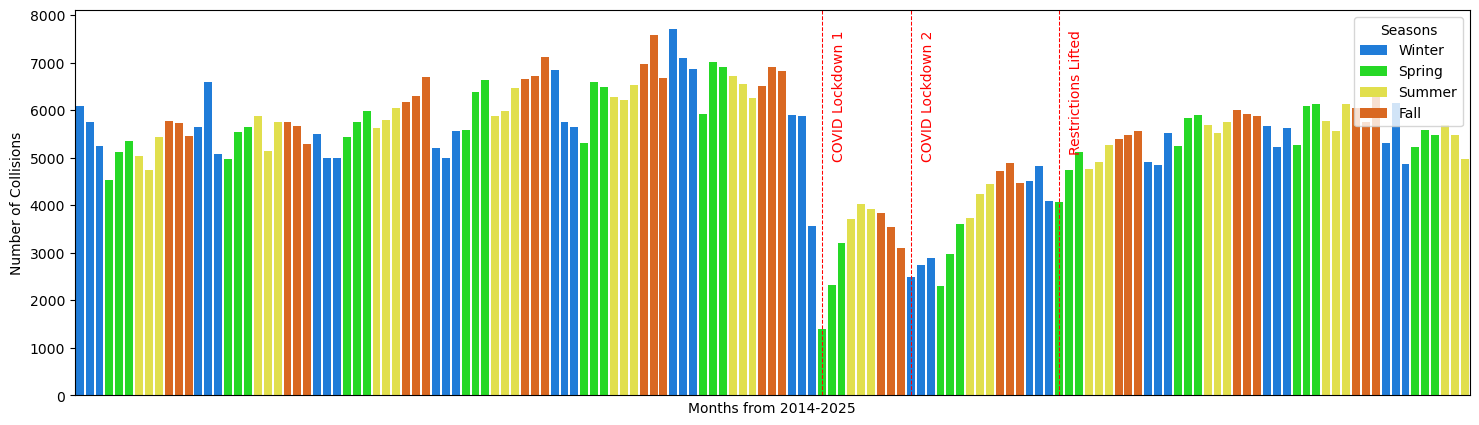

In [25]:
collisions_by_month["Season"] = np.where(collisions_by_month['OCC_MONTH'].isin(['January', 'February', 'March']), 'Winter',
                                         np.where(collisions_by_month['OCC_MONTH'].isin(['April', 'May', 'June']), 'Spring',
                                                  np.where(collisions_by_month['OCC_MONTH'].isin(['July', 'August', 'September']), 'Summer',
                                                           'Fall')))
season_colors = {
    'Winter': "#017CF7",  # Soft blue (like winter sky)
    'Spring': "#09F509",  # Sage green (like new leaves)
    'Summer': "#FAF734",  # Peach (warm summer)
    'Fall': "#F76104"     # Apricot (autumn warmth)
}

ax = sns.barplot(data=collisions_by_month, x='Month_Label', y='Collision_Count', 
                 hue='Season', palette=season_colors, dodge=False)

plt.xlabel('Months from 2014-2025')
plt.ylabel('Number of Collisions')
plt.xticks([])  # Hide x-axis labels
ax.axvline(75, ls='--', color='red', linewidth=0.75)
ax.axvline(84, ls='--', color='red', linewidth=0.75)
ax.axvline(99, ls='--', color='red', linewidth=0.75)
plt.text(x=76, y=ax.get_ylim()[1]*0.95, s='COVID Lockdown 1', color='red', fontsize=10, rotation=90, va='top')
plt.text(x=85, y=ax.get_ylim()[1]*0.95, s='COVID Lockdown 2', color='red', fontsize=10, rotation=90, va='top')
plt.text(x=100, y=ax.get_ylim()[1]*0.95, s='Restrictions Lifted', color='red', fontsize=10, rotation=90, va='top')
plt.legend(title='Seasons', loc='upper right')
plt.gcf().set_size_inches(18, 5)
plt.show()

In general, the total collisions per month were greater before the covid-lockdown. Since restrictions have been lifted, the amount of collisions have almost risen to pre-covid times. Factors such as work from home and better public transportation may be affecting the total collisions after covid since there would be less traffic volume. 

In [26]:
result = collisions_by_month.groupby('Season')['Collision_Count'].agg([('TOTAL', 'sum'), ('AVERAGE', 'mean')])

print(result)

         TOTAL      AVERAGE
Season                     
Fall    191629  5806.939394
Spring  185542  5153.944444
Summer  195834  5439.833333
Winter  190505  5291.805556


From the graph and the table above, the most average collisions happen during the Fall season. One factor could be due unexpect snowfall during that time and the people have not change to winter tires yet. Surprisingly, the Summer seaons sees the most total collisions; more than winter and fall.

In [ ]:
final_weather_df_analysis = final_weather_df
final_weather_df_analysis['Month_Label'] = final_weather_df_analysis['Date'].astype(str).str[:7]
final_weather_df_analysis['snowfall_mm'] = final_weather_df_analysis['snowfall'] * 1.42857142857
precipitation_by_month = final_weather_df_analysis.groupby(['Month_Label'])[['precipitation', 'rain', 'snowfall_mm', 'snowfall']].sum().reset_index()
precipitation_by_month['Month_Label'] = pd.to_datetime(precipitation_by_month['Month_Label'])
precipitation_by_month = precipitation_by_month.sort_values(by='Month_Label')


,Month_Label,precipitation,rain,snowfall_mm,snowfall
122,2024-03-01,62.799999,52.400002,10.400001,7.28


In [28]:
import calendar

month_dict = {
    f"{i:02d}": calendar.month_name[i]
    for i in range(1, 13)
}

precipitation_by_month['OCC_MONTH']= precipitation_by_month['Month_Label'].dt.month.astype(str).str.zfill(2)
precipitation_by_month['OCC_MONTH']= precipitation_by_month['OCC_MONTH'].map(month_dict)

In [29]:
final_weather_df['snowfall'].max()

5.110000133514404

In [30]:
precipitation_by_month[precipitation_by_month['snowfall'] == precipitation_by_month['snowfall'].max()]

,Month_Label,precipitation,rain,snowfall_mm,snowfall,OCC_MONTH
133,2025-02-01,77.5,7.6,70.0,49.0,February


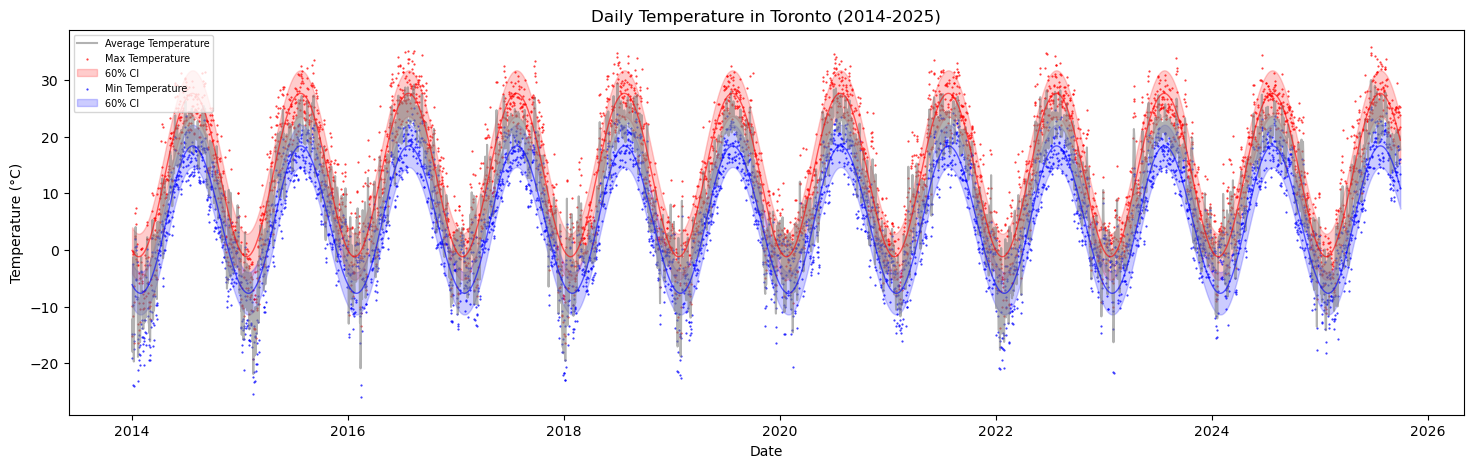

In [125]:
daily_temp = final_weather_df.groupby('Date')['temperature'].agg([('Average Temperature', 'mean'), ('Max Temperature', 'max'), ('Min Temperature', 'min')]).reset_index()

t = np.arange(len(daily_temp))
X = np.column_stack([
    np.sin(2 * np.pi * t / 365.25),
    np.cos(2 * np.pi * t / 365.25),
    np.sin(4 * np.pi * t / 365.25),
    np.cos(4 * np.pi * t / 365.25)
])


X = sm.add_constant(X)
model = sm.OLS(daily_temp['Max Temperature'], X).fit()
pred = model.get_prediction(X)
pred_summary = pred.summary_frame(alpha=0.40)
ci_lower = pred_summary['obs_ci_lower']
ci_upper = pred_summary['obs_ci_upper']

X_2 = sm.add_constant(X)
model = sm.OLS(daily_temp['Min Temperature'], X_2).fit()
pred = model.get_prediction(X_2)
pred_summary_2 = pred.summary_frame(alpha=0.40)
ci_lower_2 = pred_summary_2['obs_ci_lower']
ci_upper_2 = pred_summary_2['obs_ci_upper']

plt.figure(figsize=(18, 5))
plt.plot(daily_temp['Date'], daily_temp['Average Temperature'], label='Average Temperature', color='grey', alpha = 0.6)
plt.scatter(x=daily_temp['Date'], y=daily_temp['Max Temperature'], label='Max Temperature', color='red', s = 0.3, alpha = 0.8)
plt.fill_between(daily_temp['Date'], ci_lower, ci_upper, color='red', alpha=0.2, label='60% CI')
plt.plot(daily_temp['Date'], pred_summary['mean'], color = 'red', linewidth=1, alpha = 0.6)
plt.scatter(x=daily_temp['Date'], y=daily_temp['Min Temperature'], label='Min Temperature', color='blue', s = 0.3,alpha = 0.8)
plt.fill_between(daily_temp['Date'], ci_lower_2, ci_upper_2, color='blue', alpha=0.2, label='60% CI')
plt.plot(daily_temp['Date'], pred_summary_2['mean'], color = 'blue', linewidth=1,alpha = 0.6)
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend(prop={'size': 7}, loc = 'upper left')
plt.title('Daily Temperature in Toronto (2014-2025)')
plt.show()

Daily temperature shows a seasonal trend. 

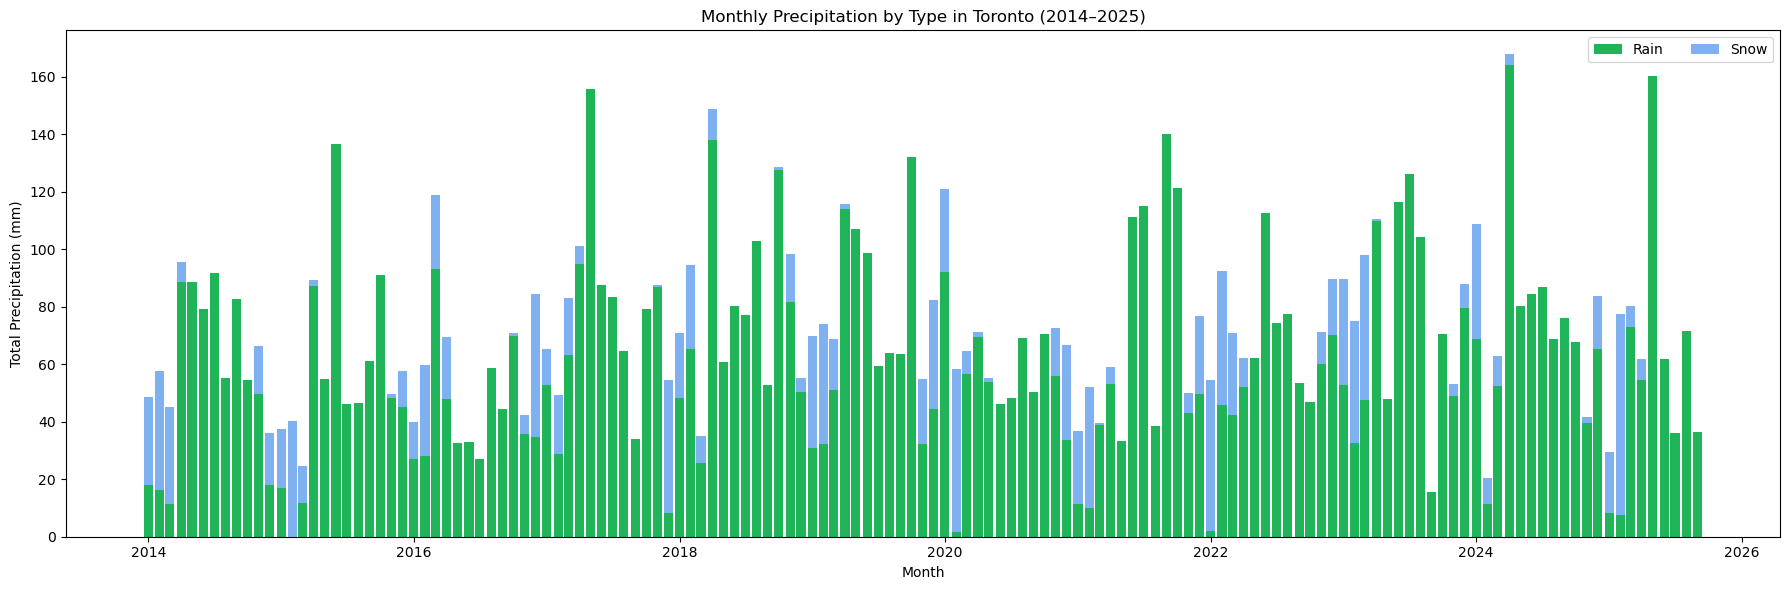

In [32]:
plt.figure(figsize=(18, 6))

plt.bar(
    precipitation_by_month['Month_Label'],
    precipitation_by_month['rain'],
    label='Rain',
    color="#1fb458", width = 25
)

plt.bar(
    precipitation_by_month['Month_Label'],
    precipitation_by_month['snowfall_mm'],
    bottom=precipitation_by_month['rain'],
    label='Snow',
    color="#7fb1f1", width = 25
)

plt.xlabel('Month')
plt.ylabel('Total Precipitation (mm)')
plt.title('Monthly Precipitation by Type in Toronto (2014–2025)')
plt.legend(ncol=3)
plt.tight_layout()
plt.show()


               rain  snowfall_mm
              TOTAL        TOTAL
Season                          
Fall    2013.099976   382.899994
Spring  3059.399902    80.199997
Summer  2404.399902     0.000000
Winter  1276.800049  1038.599976


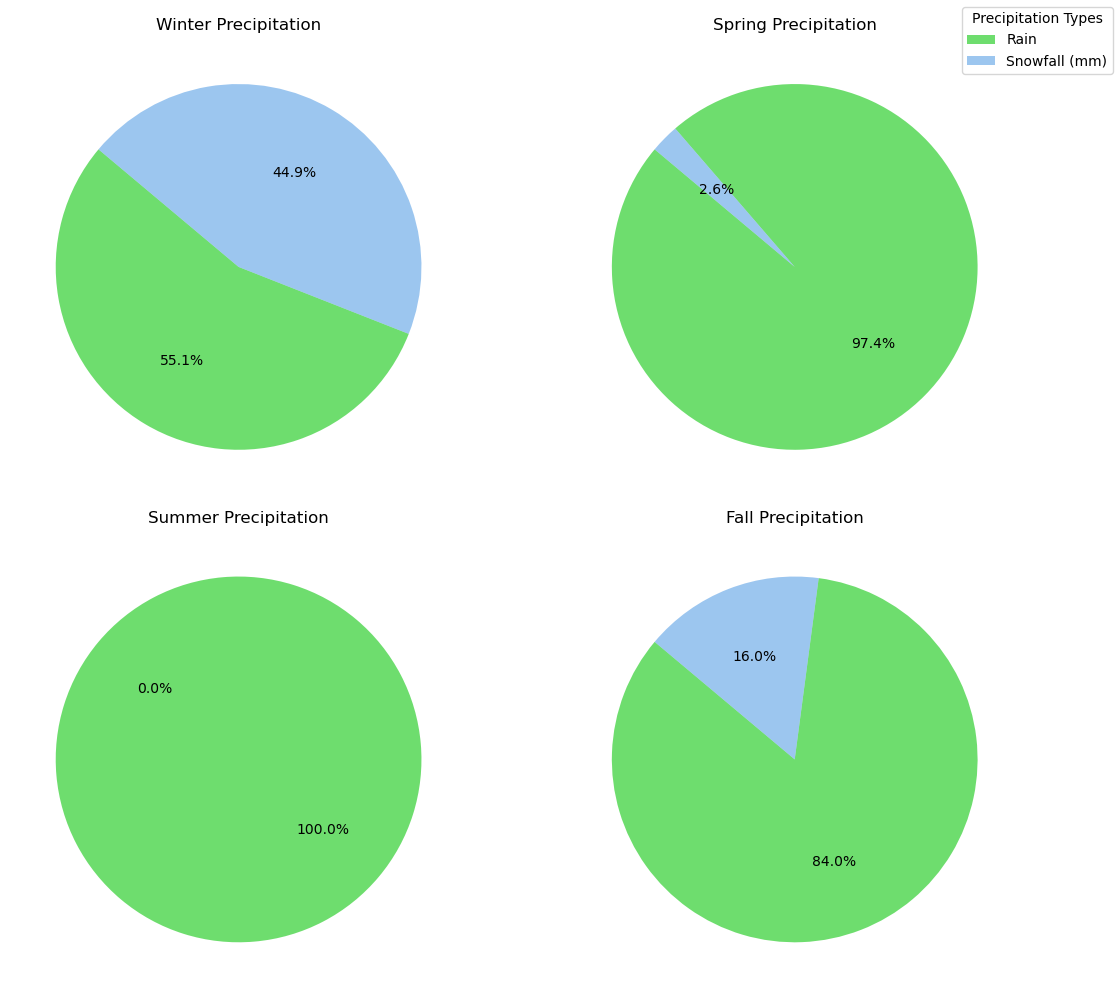

In [33]:
precipitation_by_month["Season"] = np.where(precipitation_by_month['OCC_MONTH'].isin(['January', 'February', 'March']), 'Winter',
                                         np.where(precipitation_by_month['OCC_MONTH'].isin(['April', 'May', 'June']), 'Spring',
                                                  np.where(precipitation_by_month['OCC_MONTH'].isin(['July', 'August', 'September']), 'Summer',
                                                           'Fall')))
precipitation_by_season = precipitation_by_month.groupby('Season')[['rain', 'snowfall_mm']].agg([('TOTAL', 'sum')])
print(precipitation_by_season)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

colors = ["#30CF30B2","#378CE07E","#6c757d95"]
labels = ['Rain', 'Snowfall (mm)']
seasons = ['Winter', 'Spring', 'Summer', 'Fall']

for i, season in enumerate(seasons):
    season_data = precipitation_by_season.loc[season]
    wedges, texts, autotexts = axes[i].pie(season_data, colors = colors, autopct='%1.1f%%', startangle=140)
    axes[i].set_title(f'{season} Precipitation')
fig.legend(wedges, labels, title = 'Precipitation Types', loc='upper right')
plt.tight_layout()
plt.show()


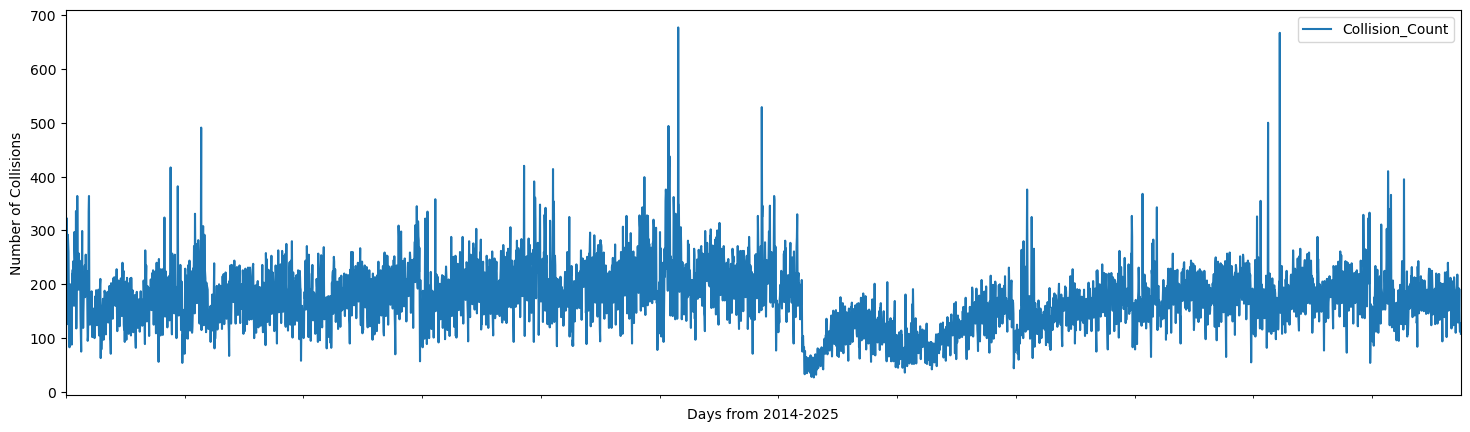

In [34]:
collisions_by_day = traffic_collision_df.groupby('Date').size().reset_index(name = 'Collision_Count')
collisions_by_day['Date'] = pd.to_datetime(collisions_by_day['Date'])
collisions_by_day = collisions_by_day.sort_values(by='Date')
collisions_by_day.plot(kind = 'line', x= 'Date', y= 'Collision_Count', xlabel = 'Days from 2014-2025', ylabel = 'Number of Collisions')
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gcf().set_size_inches(18, 5)
plt.show()

In [35]:
traffic_weather_df['Time_of_Day'] = np.where(traffic_weather_df['LTS_Hour'].isin(range(0,5)), 'Late Night',
                                             np.where(traffic_weather_df['LTS_Hour'].isin(range(5,7)), 'Early Morning',
                                                      np.where(traffic_weather_df['LTS_Hour'].isin(range(7,10)), 'AM Rush Hour',
                                                               np.where(traffic_weather_df['LTS_Hour'].isin(range(10,15)), 'Midday',
                                                                        np.where(traffic_weather_df['LTS_Hour'].isin(range(15,19)), 'PM Rush Hour', 
                                                                                 np.where(traffic_weather_df['LTS_Hour'].isin(range(19,21)), 'Evening', 
                                                                                          np.where(traffic_weather_df['LTS_Hour'].isin(range(21,24)), 'Night', None)))))))



In [36]:
statutory_holidays = [
    # 2014
    '2014-01-01', '2014-02-17', '2014-04-18', '2014-05-19', '2014-07-01',
    '2014-08-04', '2014-09-01', '2014-10-13', '2014-12-25', '2014-12-26',
    
    # 2015
    '2015-01-01', '2015-02-16', '2015-04-03', '2015-05-18', '2015-07-01',
    '2015-08-03', '2015-09-07', '2015-10-12', '2015-12-25', '2015-12-28',  # Boxing Day observed
    
    # 2016
    '2016-01-01', '2016-02-15', '2016-03-25', '2016-05-23', '2016-07-01',
    '2016-08-01', '2016-09-05', '2016-10-10', '2016-12-26', '2016-12-27',  # Christmas observed
    
    # 2017
    '2017-01-02',  # New Year's observed
    '2017-02-20', '2017-04-14', '2017-05-22', '2017-07-03',  # Canada Day observed
    '2017-08-07', '2017-09-04', '2017-10-09', '2017-12-25', '2017-12-26',
    
    # 2018
    '2018-01-01', '2018-02-19', '2018-03-30', '2018-05-21', '2018-07-02',  # Canada Day observed
    '2018-08-06', '2018-09-03', '2018-10-08', '2018-12-25', '2018-12-26',
    
    # 2019
    '2019-01-01', '2019-02-18', '2019-04-19', '2019-05-20', '2019-07-01',
    '2019-08-05', '2019-09-02', '2019-10-14', '2019-12-25', '2019-12-26',
    
    # 2020
    '2020-01-01', '2020-02-17', '2020-04-10', '2020-05-18', '2020-07-01',
    '2020-08-03', '2020-09-07', '2020-10-12', '2020-12-25', '2020-12-28',  # Boxing Day observed
    
    # 2021
    '2021-01-01', '2021-02-15', '2021-04-02', '2021-05-24', '2021-07-01',
    '2021-08-02', '2021-09-06', '2021-10-11', '2021-12-27', '2021-12-28',  # Both observed
    
    # 2022
    '2022-01-03',  # New Year's observed
    '2022-02-21', '2022-04-15', '2022-05-23', '2022-07-01',
    '2022-08-01', '2022-09-05', '2022-10-10', '2022-12-26', '2022-12-27',  # Christmas observed
    
    # 2023
    '2023-01-02',  # New Year's observed
    '2023-02-20', '2023-04-07', '2023-05-22', '2023-07-03',  # Canada Day observed
    '2023-08-07', '2023-09-04', '2023-10-09', '2023-12-25', '2023-12-26',
    
    # 2024
    '2024-01-01', '2024-02-19', '2024-03-29', '2024-05-20', '2024-07-01',
    '2024-08-05', '2024-09-02', '2024-10-14', '2024-12-25', '2024-12-26',
    
    # 2025
    '2025-01-01', '2025-02-17', '2025-04-18', '2025-05-19', '2025-07-01',
    '2025-08-04', '2025-09-01', '2025-10-13', '2025-12-25', '2025-12-26',
    '2025-12-31', '2026-01-01'
]

holiday_dates = pd.to_datetime(statutory_holidays)

In [37]:
traffic_weather_df['collision'] = np.where(traffic_weather_df['OBJECTID'].isna(), 0, 1)

In [38]:
traffic_weather_daily_sum = traffic_weather_df.groupby(['Date', 'LTS_Hour'])['collision'].sum().reset_index()

regression_df = pd.merge(traffic_weather_daily_sum, final_weather_df, how = 'left', on = ['Date', 'LTS_Hour'])

regression_df['DOW'] = regression_df['Date'].dt.day_name()
regression_df['Holiday/Weekend'] = np.where(regression_df['DOW'].isin(['Saturday', 'Sunday', 'Friday']), 1, 
                                                 np.where(regression_df['Date'].isin(holiday_dates), 1, 0))

regression_df['Rush_Hour'] = np.where((regression_df['LTS_Hour'].isin(range(7,10)) | (regression_df['LTS_Hour'].isin(range(15,19)))), 1, 0)

regression_df['Winter'] = np.where(regression_df['Date'].dt.month.isin([12, 1, 2]), 1, 0)
regression_df['Spring'] = np.where(regression_df['Date'].dt.month.isin([3, 4, 5]), 1, 0)
regression_df['Summer'] = np.where(regression_df['Date'].dt.month.isin([6, 7, 8]), 1, 0)
regression_df['Fall'] = np.where(regression_df['Date'].dt.month.isin([9, 10, 11]), 1, 0)
regression_df['Covid_Lockdown'] = np.where(regression_df['Date'].between('2020-03-22', '2022-03-30'), 1, 0)

regression_df['Winter'] = regression_df['Winter'].astype('category')
regression_df['Spring'] = regression_df['Spring'].astype('category')
regression_df['Summer'] = regression_df['Summer'].astype('category')
regression_df['Fall'] = regression_df['Fall'].astype('category')
regression_df['Rush_Hour'] = regression_df['Rush_Hour'].astype('category')
regression_df['Holiday/Weekend'] = regression_df['Holiday/Weekend'].astype('category')
regression_df['Covid_Lockdown'] = regression_df['Covid_Lockdown'].astype('category')

In [39]:
cols = [
    'precipitation', 'rain', 'snowfall', 'snow_depth',
    'temperature_2m', 'relative_humidity_2m',
    'wind_speed_10m', 'visibility',
    'Holiday/Weekend', 'Rush_Hour', 'Winter', 'Spring', 'Summer', 'Fall', 'Covid_Lockdown'
]

regression_df[regression_df[cols].isna().any(axis=1)]

,Date,LTS_Hour,collision,date,temperature_2m,relative_humidity_2m,dew_point_2m,precipitation,rain,snowfall,...,Month_Label,snowfall_mm,DOW,Holiday/Weekend,Rush_Hour,Winter,Spring,Summer,Fall,Covid_Lockdown
13966,2015-08-05,23,2,2015-08-05 23:00:00+00:00,20.783499,50.005512,9.983500,0.0,0.0,0.0,...,2015-08,0.0,Wednesday,0,0,0,0,1,0,0
13987,2015-08-06,20,6,2015-08-06 20:00:00+00:00,22.333500,49.756767,11.333500,0.0,0.0,0.0,...,2015-08,0.0,Thursday,0,0,0,0,1,0,0
13997,2015-08-07,6,1,2015-08-07 06:00:00+00:00,17.483500,77.132889,13.433500,0.0,0.0,0.0,...,2015-08,0.0,Friday,1,0,0,0,1,0,0
14000,2015-08-07,9,7,2015-08-07 09:00:00+00:00,15.933500,88.492737,14.033501,0.0,0.0,0.0,...,2015-08,0.0,Friday,1,1,0,0,1,0,0
15131,2015-09-23,12,14,2015-09-23 12:00:00+00:00,12.083500,98.691353,11.883499,0.0,0.0,0.0,...,2015-09,0.0,Wednesday,0,0,0,0,0,1,0
16086,2015-11-02,6,9,2015-11-02 06:00:00+00:00,7.283500,80.406189,4.133500,0.0,0.0,0.0,...,2015-11,0.0,Monday,0,0,0,0,0,1,0
16233,2015-11-08,9,5,2015-11-08 09:00:00+00:00,3.933500,82.258804,1.183500,0.0,0.0,0.0,...,2015-11,0.0,Sunday,1,1,0,0,0,1,0
17083,2015-12-13,19,5,2015-12-13 19:00:00+00:00,5.233500,89.727570,3.683500,0.0,0.0,0.0,...,2015-12,0.0,Sunday,1,0,1,0,0,0,0
30144,2017-06-10,1,2,2017-06-10 01:00:00+00:00,20.049999,72.713394,15.000000,0.0,0.0,0.0,...,2017-06,0.0,Saturday,1,0,0,0,1,0,0
33781,2017-11-08,13,10,2017-11-08 13:00:00+00:00,0.150000,80.550110,-2.800000,0.0,0.0,0.0,...,2017-11,0.0,Wednesday,0,0,0,0,0,1,0


In [40]:
regression_df_final = regression_df.dropna(subset=['visibility'])
regression_df_final = regression_df_final.rename(columns= {'Holiday/Weekend': 'Holiday_Weekend'})

In [41]:
#Features
X = regression_df_final[['precipitation', 'rain', 'snowfall', 'snow_depth',
    'temperature_2m', 'relative_humidity_2m',
    'wind_speed_10m', 'visibility',
    'Holiday_Weekend', 'Rush_Hour']]
y = regression_df_final['collision']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = PoissonRegressor()
model.fit(X_train, y_train)



c:\Users\prana\anaconda3\Lib\site-packages\sklearn\linear_model\_glm\glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


PoissonRegressor()

In [42]:
print(model.coef_)
print(model.intercept_)

[ 2.18978629e-03 -1.97600615e-03  2.95011163e-03  7.26056353e-03
  4.40428578e-03 -1.28534861e-03  1.06019778e-02 -1.12347052e-05
 -1.05272430e-01  4.84486587e-01]
2.0216777563686392


In [43]:
y_pred = model.predict(X_test)
error = np.subtract(y_test, y_pred)
print(error.mean())
print(metrics.r2_score(y_test, y_pred))
print("Mean Absolute Error:", metrics.mean_absolute_error(y_test, y_pred))
print("Mean Squared Error:", metrics.mean_squared_error(y_test, y_pred))

0.06208923427572491
0.15752390564503738
Mean Absolute Error: 4.730101344537013
Mean Squared Error: 38.603384595971505


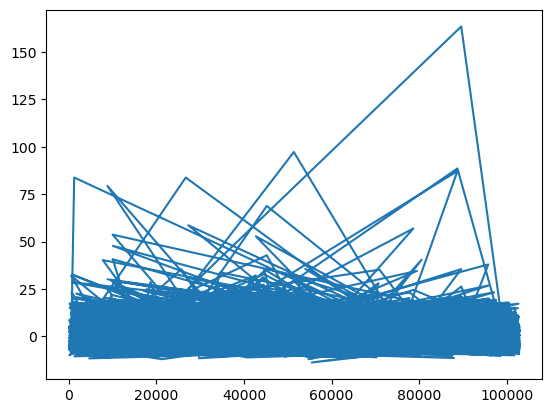

In [44]:
plt.plot(error)


In [45]:
daily_weather = pd.read_csv("/Users/prana/Documents/Personal Project/Traffic Collison/weatherstats_toronto_daily_1.csv")
daily_weather_df = pd.DataFrame(daily_weather)

In [46]:
daily_weather_df['date'] = pd.to_datetime(daily_weather_df['date'])
daily_weather_df['DOW'] = daily_weather_df['date'].dt.day_name()
daily_weather_df['Holiday_Weekend'] = np.where(daily_weather_df['DOW'].isin(['Saturday', 'Sunday','Friday']), 1, 
                                                 np.where(daily_weather_df['date'].isin(holiday_dates), 1, 0))
daily_weather_df['Holiday_Weekend']  = daily_weather_df['Holiday_Weekend'].astype('category')
daily_weather_df['Winter'] = np.where(daily_weather_df['date'].dt.month.isin([12,1,2]), 1, 0)
daily_weather_df['Spring'] = np.where(daily_weather_df['date'].dt.month.isin([3,4,5]), 1, 0)
daily_weather_df['Summer'] = np.where(daily_weather_df['date'].dt.month.isin([6,7,8]), 1, 0)
daily_weather_df['Fall'] = np.where(daily_weather_df['date'].dt.month.isin([9,10,11]), 1, 0)
daily_weather_df['Covid_Lockdown'] = np.where(daily_weather_df['date'].between('2020-03-22', '2022-03-30'), 1, 0)

daily_weather_df['Winter'] = daily_weather_df['Winter'].astype('category')
daily_weather_df['Spring'] = daily_weather_df['Spring'].astype('category')
daily_weather_df['Summer'] = daily_weather_df['Summer'].astype('category')
daily_weather_df['Fall'] = daily_weather_df['Fall'].astype('category')
daily_weather_df['Covid_Lockdown'] = daily_weather_df['Covid_Lockdown'].astype('category')



In [47]:
cols = [
    'avg_temperature', 'avg_wind_speed','avg_visibility',
    'rain','snow', 'Holiday_Weekend', 'Winter', 'Spring', 'Summer', 'Fall', 'Covid_Lockdown'
]
daily_weather_df[cols].isna().sum()

avg_temperature     0
avg_wind_speed      0
avg_visibility      0
rain               30
snow               21
Holiday_Weekend     0
Winter              0
Spring              0
Summer              0
Fall                0
Covid_Lockdown      0
dtype: int64

In [48]:
daily_weather_df['rain'] =  np.where(daily_weather_df['rain'].isna() & daily_weather_df['precipitation'] == 0, 0, daily_weather_df['rain'])

In [49]:
cols = [
    'avg_temperature', 'avg_wind_speed','avg_visibility',
    'rain','snow', 'Holiday_Weekend', 'Winter', 'Spring', 'Summer', 'Fall', 'Covid_Lockdown'
]
daily_weather_df[cols].isna().sum()

avg_temperature     0
avg_wind_speed      0
avg_visibility      0
rain                5
snow               21
Holiday_Weekend     0
Winter              0
Spring              0
Summer              0
Fall                0
Covid_Lockdown      0
dtype: int64

In [50]:
daily_weather_df = daily_weather_df.dropna(subset=['rain', 'snow'])



In [51]:
traffic_collision_df['collisions'] = np.where(traffic_collision_df['OBJECTID'].isna(), 0, 1)
daily_collision_sum = traffic_collision_df.groupby('Date')['collisions'].sum().reset_index()
daily_regression_df = pd.merge(daily_collision_sum, daily_weather_df, how = 'inner', left_on = 'Date', right_on = 'date')

In [52]:
X_daily = daily_regression_df[['avg_temperature', 'avg_wind_speed','avg_visibility',
    'rain','snow', 'Holiday_Weekend', 'Winter', 'Spring', 'Summer', 'Fall', 'Covid_Lockdown']]
y_daily = daily_regression_df['collisions']
X_train_daily, X_test_daily, y_train_daily, y_test_daily = train_test_split(X_daily, y_daily, train_size=0.8, random_state=42)
model_daily = PoissonRegressor()
model_daily.fit(X_train_daily, y_train_daily)

c:\Users\prana\anaconda3\Lib\site-packages\sklearn\linear_model\_glm\glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


PoissonRegressor()

In [53]:
print(model_daily.coef_)
print(model_daily.intercept_)

[ 1.08293994e-03 -1.63871836e-04 -7.62079387e-07  0.00000000e+00
  4.78487417e-02 -1.84927533e-02  2.22737844e-03 -1.05641125e-02
  2.13326313e-03  8.06422831e-03 -2.74172492e-02]
5.182421828734257


In [54]:
y_pred_daily = model_daily.predict(X_test_daily)
error_daily = np.subtract(y_test_daily, y_pred_daily)
print(error_daily.mean())
print(metrics.r2_score(y_test_daily, y_pred_daily))
print("Mean Absolute Error:", metrics.mean_absolute_error(y_test_daily, y_pred_daily))
print("Mean Squared Error:", metrics.mean_squared_error(y_test_daily, y_pred_daily))

1.9658933586931429
0.09266977908400742
Mean Absolute Error: 42.81061920331724
Mean Squared Error: 3122.6765553873583


In [55]:
print(daily_regression_df['collisions'].mean(), daily_regression_df['collisions'].var())
print(regression_df_final['collision'].mean(), regression_df_final['collision'].var())

178.07355352541578 3353.977250279519
7.414814886756536 44.02558046451677


In [56]:
daily_regression_df.head(5)

,Date,collisions,date,max_temperature,avg_hourly_temperature,avg_temperature,min_temperature,max_humidex,min_windchill,max_relative_humidity,...,avg_hourly_cloud_cover_10,avg_cloud_cover_10,min_cloud_cover_10,DOW,Holiday_Weekend,Winter,Spring,Summer,Fall,Covid_Lockdown
0,2014-01-01,69,2014-01-01,-10.0,-12.53,-12.65,-15.3,NaN,-26.0,75,...,NaN,NaN,NaN,Wednesday,1,1,0,0,0,0
1,2014-01-02,172,2014-01-02,-15.2,-17.72,-17.60,-20.0,NaN,-32.0,73,...,NaN,NaN,NaN,Thursday,0,1,0,0,0,0
2,2014-01-03,323,2014-01-03,-9.2,-17.63,-16.50,-23.8,NaN,-35.0,74,...,NaN,NaN,NaN,Friday,1,1,0,0,0,0
3,2014-01-04,172,2014-01-04,-0.4,-4.18,-4.80,-9.2,NaN,-17.0,85,...,NaN,NaN,NaN,Saturday,1,1,0,0,0,0
4,2014-01-05,126,2014-01-05,-0.1,-1.25,-1.35,-2.6,NaN,-7.0,96,...,NaN,NaN,NaN,Sunday,1,1,0,0,0,0


In [57]:
mask = np.random.rand(len(daily_regression_df)) < 0.8
df_train = daily_regression_df[mask]
df_test = daily_regression_df[~mask]

expr = """ collisions ~ avg_temperature + avg_wind_speed + avg_visibility + rain + snow + Holiday_Weekend + Winter + Spring + Summer + Fall + Covid_Lockdown """
y_train_nb, X_train_nb = dmatrices(expr, df_train, return_type="dataframe")
y_test_nb, X_test_nb = dmatrices(expr, df_test, return_type="dataframe")


In [58]:
nb_training_result = sm.GLM(y_train_nb, X_train_nb, family=sm.families.NegativeBinomial()).fit()

print(nb_training_result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             collisions   No. Observations:                 3410
Model:                            GLM   Df Residuals:                     3400
Model Family:        NegativeBinomial   Df Model:                            9
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -21005.
Date:                Wed, 11 Feb 2026   Deviance:                       244.18
Time:                        12:44:10   Pearson chi2:                     240.
No. Iterations:                     6   Pseudo R-squ. (CS):            0.04567
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                4.2475 

c:\Users\prana\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


In [59]:
nb_prediction_train = nb_training_result.get_prediction(X_train_nb)
predicted_counts_train = np.round(nb_prediction_train.summary_frame()['mean'])
r2_score_train = r2_score(y_train_nb, predicted_counts_train)
print(r2_score_train)

0.38927769165577186


In [60]:
nb_prediction_test = nb_training_result.get_prediction(X_test_nb)
predicted_counts_test = np.round(nb_prediction_test.summary_frame()['mean'])
r2_score_test = r2_score(y_test_nb, predicted_counts_test)
print(r2_score_test)

0.368748178440816


In [61]:
print(predicted_counts_test.sort_index())

0       177.0
8       205.0
11      173.0
14      204.0
21      207.0
26      231.0
36      207.0
42      204.0
43      201.0
45      176.0
47      186.0
49      199.0
50      226.0
52      178.0
56      211.0
61      194.0
66      161.0
68      183.0
73      165.0
77      184.0
78      190.0
81      164.0
84      191.0
86      158.0
92      186.0
96      183.0
101     153.0
107     157.0
118     185.0
119     184.0
120     181.0
127     177.0
128     152.0
135     155.0
139     176.0
140     175.0
141     179.0
150     151.0
157     172.0
163     176.0
166     202.0
171     173.0
173     202.0
176     199.0
197     203.0
201     200.0
206     173.0
210     204.0
222     201.0
223     203.0
224     207.0
228     175.0
232     200.0
233     172.0
237     199.0
238     204.0
249     184.0
251     213.0
253     222.0
254     187.0
255     189.0
258     219.0
262     187.0
265     217.0
272     216.0
273     217.0
275     185.0
280     227.0
282     191.0
285     187.0
289     190.0
290   

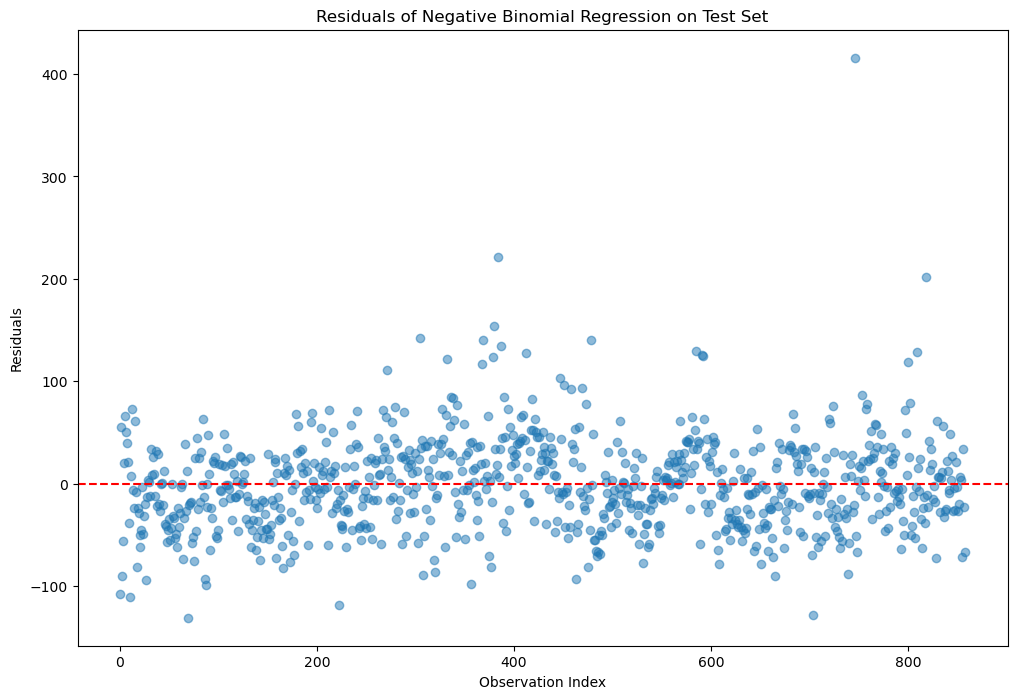

In [62]:
fig = plt.figure(figsize = (12,8))

residuals = y_test_nb.values.flatten() - predicted_counts_test.values.flatten()
plt.plot(residuals, marker='o', linestyle='', alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Observation Index')
plt.ylabel('Residuals')
plt.title('Residuals of Negative Binomial Regression on Test Set')
plt.show()

In [63]:
test_merged_df = daily_regression_df.merge(predicted_counts_test, left_index=True, right_index= True, how = 'inner')
test_merged_df = test_merged_df.rename(columns= {'mean': 'Predicted Collisions'})

<Figure size 1800x800 with 0 Axes>

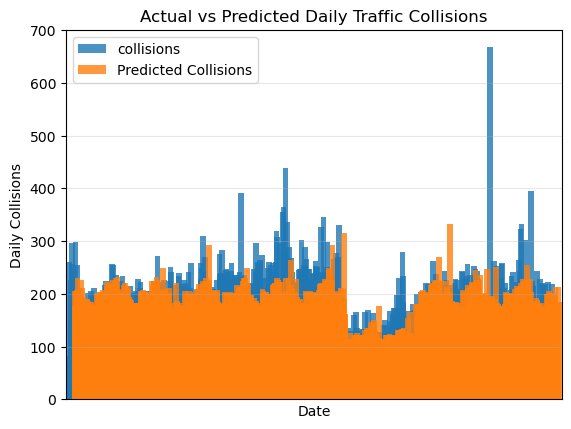

In [64]:
plt.figure(figsize=(18, 8))

test_merged_df.plot(x ='Date', y = ['collisions', 'Predicted Collisions'],
         kind = 'bar', width=20, alpha=0.8)

plt.xlabel('Date')
plt.ylabel('Daily Collisions')
plt.xticks([])
plt.title('Actual vs Predicted Daily Traffic Collisions')
plt.legend()
plt.grid(alpha=0.3)

plt.show()


In [65]:
mask_2 = np.random.rand(len(regression_df_final)) < 0.8
df_train_hourly = regression_df_final[mask_2]
df_test_hourly = regression_df_final[~mask_2]

expr = """ collision ~  rain + snowfall + snow_depth +
    temperature_2m + relative_humidity_2m +
    wind_speed_10m + visibility +
    Holiday_Weekend + Rush_Hour + Winter + Spring + Summer + Fall + Covid_Lockdown """
y_train_hourly_nb, X_train_hourly_nb = dmatrices(expr, df_train_hourly, return_type="dataframe")
y_test_hourly_nb, X_test_hourly_nb = dmatrices(expr, df_test_hourly, return_type="dataframe")

In [66]:
nb_training_result_hourly = sm.GLM(y_train_hourly_nb, X_train_hourly_nb, family=sm.families.NegativeBinomial()).fit()

print(nb_training_result_hourly.summary())

c:\Users\prana\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


                 Generalized Linear Model Regression Results                  
Dep. Variable:              collision   No. Observations:                82591
Model:                            GLM   Df Residuals:                    82577
Model Family:        NegativeBinomial   Df Model:                           13
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.4747e+05
Date:                Wed, 11 Feb 2026   Deviance:                       64772.
Time:                        12:44:13   Pearson chi2:                 4.91e+04
No. Iterations:                     8   Pseudo R-squ. (CS):             0.1315
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                1.6893 

In [67]:
nb_prediction_hourly_train = nb_training_result_hourly.get_prediction(X_train_hourly_nb)
predicted_counts_hourly_train = np.round(nb_prediction_hourly_train.summary_frame()['mean'])
r2_score_hourly_train = r2_score(y_train_hourly_nb, predicted_counts_hourly_train)
print(r2_score_hourly_train)

0.23692763294472463


In [68]:
nb_prediction_hourly_test = nb_training_result_hourly.get_prediction(X_test_hourly_nb)
predicted_counts_hourly_test = np.round(nb_prediction_hourly_test.summary_frame()['mean'])
r2_score_hourly_test = r2_score(y_test_hourly_nb, predicted_counts_hourly_test)
print(r2_score_hourly_test)

0.22856298904883343


In [71]:
daily_regression_df_2 = daily_regression_df
daily_regression_df_2['sin'] = np.sin(2 * np.pi * daily_regression_df_2['date'].dt.dayofyear / 365)
daily_regression_df_2['cos'] = np.cos(2 * np.pi * daily_regression_df_2['date'].dt.dayofyear / 365)
daily_regression_df_2['lag_collision'] = daily_regression_df_2['collisions'].shift(1).fillna(165.875) #avg collisions on new years eve
daily_regression_df_2['day_of_year'] = daily_regression_df_2['date'].dt.dayofyear
daily_regression_df_2["day_collisions_lag_seven"] = daily_regression_df_2['collisions'].shift(7)

daily_regression_df_2 = daily_regression_df_2.dropna(subset=['day_collisions_lag_seven'])



In [72]:
df_train = daily_regression_df_2[daily_regression_df_2['date'].between('2014-01-08', '2024-09-30')]
df_test = daily_regression_df_2[daily_regression_df_2['date'] > '2024-09-30']

expr = """ collisions ~ avg_temperature + avg_wind_speed + avg_visibility + rain + snow + sin + cos +Holiday_Weekend + Covid_Lockdown  + lag_collision +
           avg_wind_speed:snow + Holiday_Weekend:snow + day_collisions_lag_seven"""
y_train_nb, X_train_nb = dmatrices(expr, df_train, return_type="dataframe")
y_test_nb, X_test_nb = dmatrices(expr, df_test, return_type="dataframe")


In [73]:
nb_training_result = sm.GLM(y_train_nb, X_train_nb, family=sm.families.NegativeBinomial()).fit()

print(nb_training_result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             collisions   No. Observations:                 3898
Model:                            GLM   Df Residuals:                     3885
Model Family:        NegativeBinomial   Df Model:                           12
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -23951.
Date:                Wed, 11 Feb 2026   Deviance:                       181.96
Time:                        12:44:29   Pearson chi2:                     176.
No. Iterations:                     7   Pseudo R-squ. (CS):            0.07269
Covariance Type:            nonrobust                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

c:\Users\prana\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


In [74]:
nb_prediction_train = nb_training_result.get_prediction(X_train_nb)
predicted_counts_train = nb_prediction_train.summary_frame()['mean']
r2_score_train = r2_score(y_train_nb, predicted_counts_train)
print(r2_score_train)

0.5423978951389772


In [75]:
nb_prediction_test = nb_training_result.get_prediction(X_test_nb)
predicted_counts_test = nb_prediction_test.summary_frame()['mean']
r2_score_test = r2_score(y_test_nb, predicted_counts_test)
print(r2_score_test)

0.2211532730977639


In [76]:
nb_prediction_train.summary_frame(alpha=0.05).head()

,mean,mean_se,mean_ci_lower,mean_ci_upper
7,200.475514,17.108548,169.597689,236.975113
8,231.396353,14.408499,204.811444,261.432032
9,267.513738,20.995899,229.371403,311.998789
10,156.722518,8.176251,141.489435,173.595630
11,128.778817,7.068808,115.643456,143.406158


In [77]:
metrics = {
        'MAE': mean_absolute_error(y_test_nb, predicted_counts_test),
        'RMSE': np.sqrt(mean_squared_error(y_test_nb, predicted_counts_test)),
        'MAPE': mean_absolute_percentage_error(y_test_nb, predicted_counts_test),
        'Mean Prediction': np.mean(predicted_counts_test),
        'Mean Actual': np.mean(y_test_nb)
    }

print(metrics)

{'MAE': 28.08256970592802, 'RMSE': np.float64(40.14837577083204), 'MAPE': 0.1622719353964845, 'Mean Prediction': np.float64(186.92405649475853), 'Mean Actual': np.float64(183.07142857142858)}


In [78]:
metrics = {
        'MAE': mean_absolute_error(y_train_nb, predicted_counts_train),
        'RMSE': np.sqrt(mean_squared_error(y_train_nb, predicted_counts_train)),
        'MAPE': mean_absolute_percentage_error(y_train_nb, predicted_counts_train),
        'Mean Prediction': np.mean(predicted_counts_train),
        'Mean Actual': np.mean(y_train_nb)
    }

print(metrics)

{'MAE': 27.949336998006643, 'RMSE': np.float64(39.81330627646936), 'MAPE': 0.17552035119635923, 'Mean Prediction': np.float64(178.22804338669135), 'Mean Actual': np.float64(177.5800410466906)}


<Axes: xlabel='collisions', ylabel='Count'>

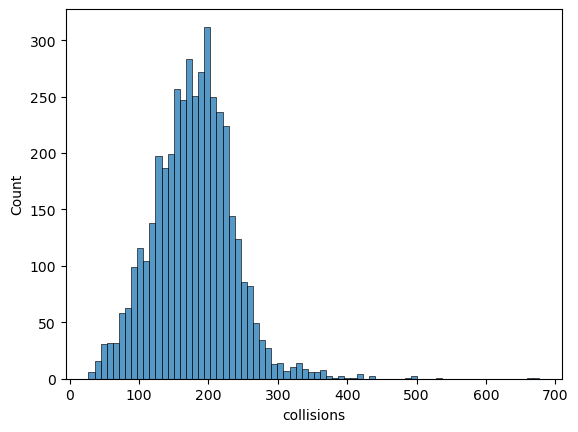

In [ ]:
sns.histplot(data=daily_regression_df_2, x='collisions')

In [79]:
daily_dataframe_forecast = pd.read_csv("/Users/prana/Documents/Personal Project/Traffic Collison/weatherstats_toronto_daily_forecast.csv")
traffic_collisions_updated = pd.read_csv("/Users/prana/Documents/Personal Project/Traffic Collison/Traffic_Collisions_Open_Data_2025.csv")

In [ ]:
traffic_collisions_updated.head()

,OBJECTID,EVENT_UNIQUE_ID,OCC_DATE,OCC_MONTH,OCC_DOW,OCC_YEAR,OCC_HOUR,DIVISION,FATALITIES,INJURY_COLLISIONS,...,NEIGHBOURHOOD_158,LONG_WGS84,LAT_WGS84,AUTOMOBILE,MOTORCYCLE,PASSENGER,BICYCLE,PEDESTRIAN,x,y
0,1,GO-20148000012,1/1/2014 5:00:00 AM,January,Wednesday,2014,18,D41,0,NO,...,Dorset Park (126),-79.281097,43.765821,YES,NO,NO,NO,NO,-8.825531e+06,5.429274e+06
1,2,GO-20148002064,1/1/2014 5:00:00 AM,January,Wednesday,2014,17,D32,0,NO,...,Newtonbrook East (50),-79.415990,43.781633,YES,NO,NO,NO,NO,-8.840548e+06,5.431711e+06
2,3,GO-20141260499,1/1/2014 5:00:00 AM,January,Wednesday,2014,2,NSA,0,YES,...,NSA,0.000000,0.000000,YES,NO,NO,NO,NO,6.327780e-09,5.664924e-09
3,4,GO-20141260663,1/1/2014 5:00:00 AM,January,Wednesday,2014,3,NSA,0,NO,...,NSA,0.000000,0.000000,YES,NO,NO,NO,NO,6.327780e-09,5.664924e-09
4,5,GO-20141261162,1/1/2014 5:00:00 AM,January,Wednesday,2014,5,NSA,0,YES,...,NSA,0.000000,0.000000,YES,NO,NO,NO,NO,6.327780e-09,5.664924e-09


In [96]:
daily_dataframe_forecast['date'] = pd.to_datetime(daily_dataframe_forecast['date'])
daily_dataframe_forecast['sin'] = np.sin(2 * np.pi * daily_dataframe_forecast['date'].dt.dayofyear / 365)
daily_dataframe_forecast['cos'] = np.cos(2 * np.pi * daily_dataframe_forecast['date'].dt.dayofyear / 365)
daily_dataframe_forecast['Holiday_Weekend'] = np.where(daily_dataframe_forecast['date'].dt.day_name().isin(['Saturday', 'Sunday','Friday']), 1, 
                                                 np.where(daily_dataframe_forecast['date'].isin(holiday_dates), 1, 0))
daily_dataframe_forecast['Covid_Lockdown'] = np.where(daily_dataframe_forecast['date'].between('2020-03-22', '2022-03-30'), 1, 0)
daily_weather_df['Covid_Lockdown'] = daily_weather_df['Covid_Lockdown'].astype('category')
daily_dataframe_forecast['Holiday_Weekend']  = daily_dataframe_forecast['Holiday_Weekend'].astype('category')



In [97]:
traffic_collisions_updated['Date'] = traffic_collisions_updated['OCC_DATE'].astype(str).str.split(' ').str[0]
traffic_collisions_updated['Date'] = pd.to_datetime(traffic_collisions_updated['Date'])
traffic_collisions_updated = traffic_collisions_updated[(traffic_collisions_updated['AUTOMOBILE'] == 'YES') | (traffic_collisions_updated['MOTORCYCLE'] == 'YES')]
traffic_collisions_updated['collisions'] = np.where(traffic_collisions_updated['OBJECTID'].isna(), 0, 1)
daily_collision_sum_2 = traffic_collisions_updated.groupby('Date')['collisions'].sum().reset_index()
daily_collision_sum_2.tail()

,Date,collisions
4378,2025-12-27,170
4379,2025-12-28,119
4380,2025-12-29,421
4381,2025-12-30,148
4382,2025-12-31,156


In [98]:
daily_collisions_forecast = pd.merge(daily_collision_sum_2, daily_dataframe_forecast, how = 'right', left_on = 'Date', right_on = 'date')
daily_collisions_forecast = daily_collisions_forecast.sort_values(by='date', ascending=True)

In [99]:
daily_collisions_forecast['lag_collision'] = daily_collisions_forecast['collisions'].shift(1) 
daily_collisions_forecast['day_of_year'] = daily_collisions_forecast['date'].dt.dayofyear
daily_collisions_forecast["day_collisions_lag_seven"] = daily_collisions_forecast['collisions'].shift(7)

In [100]:
daily_collisions_forecast_final = daily_collisions_forecast.dropna(subset=['day_collisions_lag_seven'])

daily_collisions_forecast_final = daily_collisions_forecast_final.drop(columns=['collisions'])

In [119]:
daily_collisions_forecast_final['Covid_Lockdown'] = daily_collisions_forecast_final['Covid_Lockdown'].astype('category')
x = pd.concat([daily_collisions_forecast_final, daily_regression_df_2]).drop(columns = ['collisions'])

In [120]:
from patsy import dmatrix

final_training_set = daily_regression_df_2

expr = """ collisions ~ avg_temperature + avg_wind_speed + avg_visibility + rain + snow + sin + cos +Holiday_Weekend + Covid_Lockdown +
           avg_wind_speed:snow + Holiday_Weekend:snow + day_collisions_lag_seven"""

expr_rhs = """ Covid_Lockdown + avg_temperature + avg_wind_speed + avg_visibility + rain + snow + sin + cos + Covid_Lockdown +
               Holiday_Weekend  + avg_wind_speed:snow + 
               Holiday_Weekend:snow + day_collisions_lag_seven"""

y_final_train, X_final_train = dmatrices(expr, final_training_set, return_type="dataframe")
X_forecast = dmatrix(expr_rhs, x, return_type="dataframe")

In [ ]:
X_final_train

In [112]:
X_forecast

,Intercept,Holiday_Weekend[T.1],avg_temperature,avg_wind_speed,avg_visibility,rain,snow,Holiday_Weekend[T.1]:snow,sin,cos,avg_wind_speed:snow,day_collisions_lag_seven
19,1.0,1.0,2.20,35.0,14450.0,3.8,0.0,0.0,-2.051045e-01,0.978740,0.0,233.0
18,1.0,1.0,-0.14,20.5,24100.0,0.0,0.0,0.0,-1.882267e-01,0.982126,0.0,215.0
17,1.0,1.0,-1.14,31.5,20100.0,0.0,0.0,0.0,-1.712931e-01,0.985220,0.0,169.0
16,1.0,0.0,-1.80,17.0,16100.0,2.1,0.2,0.0,-1.543088e-01,0.988023,3.4,191.0
15,1.0,0.0,1.95,19.5,12450.0,0.0,9.8,0.0,-1.372788e-01,0.990532,191.1,232.0
14,1.0,0.0,0.50,28.0,24100.0,0.0,0.0,0.0,-1.202080e-01,0.992749,0.0,204.0
13,1.0,1.0,-2.65,19.5,24100.0,0.0,0.0,0.0,-1.031017e-01,0.994671,0.0,196.0
12,1.0,1.0,-5.60,27.5,12650.0,0.0,12.0,12.0,-8.596480e-02,0.996298,330.0,189.0
11,1.0,1.0,-6.10,10.0,13850.0,0.0,0.0,0.0,-6.880243e-02,0.997630,0.0,164.0
10,1.0,1.0,-0.30,12.5,14050.0,41.2,0.0,0.0,-5.161967e-02,0.998667,0.0,123.0


In [121]:
nb_training_result_final = sm.GLM(y_final_train, X_final_train, family=sm.families.NegativeBinomial()).fit()
print(nb_training_result_final.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             collisions   No. Observations:                 4262
Model:                            GLM   Df Residuals:                     4250
Model Family:        NegativeBinomial   Df Model:                           11
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -26229.
Date:                Wed, 11 Feb 2026   Deviance:                       236.88
Time:                        13:03:17   Pearson chi2:                     225.
No. Iterations:                     7   Pseudo R-squ. (CS):            0.05956
Covariance Type:            nonrobust                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

c:\Users\prana\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


In [123]:
nb_prediction_train_final = nb_training_result_final.get_prediction(X_forecast)
predicted_counts_train_final = nb_prediction_train_final.summary_frame()
predicted_counts_train_final.head(20)

,mean,mean_se,mean_ci_lower,mean_ci_upper
19,198.715601,11.858639,176.780879,223.371952
18,182.481300,7.301534,168.717317,197.368150
17,167.280805,7.995751,152.321096,183.709732
16,199.312489,6.746457,186.518749,212.983779
15,326.973959,43.216034,252.353978,423.658747
14,200.851160,9.348265,183.339761,220.035132
13,174.187972,6.651576,161.627038,187.725086
12,286.801523,71.895356,175.469807,468.770755
11,164.347652,7.957289,149.468791,180.707629
10,143.538097,6.700111,130.988921,157.289525
